## Setup

### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
from datetime import datetime

from IPython import display

import stockcore.data as scdata
import stockcore.models as scmodels
import stockcore.environment as scenv
import stockcore.utils as scutils
from stocksense.api import data as api_data

In [2]:
is_ipython = scutils.setup_mpl()
device = scutils.get_device()

if is_ipython:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

### Data

In [3]:
msft_df = await api_data.get_kline_df('yfinance', 'MSFT', datetime(2000, 1, 1), datetime(2024, 2, 1), '1d')
aapl_df = await api_data.get_kline_df('yfinance', 'AAPL', datetime(2000, 1, 1), datetime(2024, 2, 1), '1d')
dfs = [msft_df, aapl_df]

print(msft_df.shape)
print(aapl_df.shape)
print(msft_df.head(5))
print(aapl_df.head(5))

(6058, 6)
(6058, 6)
                                   unix     close     high       low  \
date                                                                   
2000-01-03 00:00:00+00:00  946857600000  58.28125  59.3125  56.00000   
2000-01-04 00:00:00+00:00  946944000000  56.31250  58.5625  56.12500   
2000-01-05 00:00:00+00:00  947030400000  56.90625  58.1875  54.68750   
2000-01-06 00:00:00+00:00  947116800000  55.00000  56.9375  54.18750   
2000-01-07 00:00:00+00:00  947203200000  55.71875  56.1250  53.65625   

                               open    volume  
date                                           
2000-01-03 00:00:00+00:00  58.68750  53228400  
2000-01-04 00:00:00+00:00  56.78125  54119000  
2000-01-05 00:00:00+00:00  55.56250  64059600  
2000-01-06 00:00:00+00:00  56.09375  54976600  
2000-01-07 00:00:00+00:00  54.31250  62013600  
                                   unix     close      high       low  \
date                                                              

### Environment

In [4]:
env = scenv.MultiStockTradingEnv(name= "MY_ENV", dfs=dfs, trading_fees=0.01/100)

## Baseline: Random Agent

In [5]:
# Eatch step, the environment will return 5 inputs  : "feature_close", "feature_open", "feature_high", "feature_low", "feature_volume"
# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
# pbar = tqdm(total=env.get_dfs_length())
while not done and not truncated:
    position_index = env.action_space.sample()
    # pbar.update(1)
    observation, reward, done, truncated, info = env.step(position_index)
history_random = env.get_history()

Portfolio Return : 362.25%


## Baseline: Buy and Hold

In [6]:
env_for_buy_and_hold = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_BUY_AND_HOLD", dfs=dfs, trading_fees=0, strategy='buy_and_hold')
done, truncated = False, False
observation, info = env_for_buy_and_hold.reset()
# pbar = tqdm(total=env_for_buy_and_hold.get_dfs_length())
while not done and not truncated:
    position_index = [0, 1, 0]
    # pbar.update(1)
    observation, reward, done, truncated, info = env_for_buy_and_hold.step(position_index)
history_buy_and_hold = env_for_buy_and_hold.get_history()

Portfolio Return : 17919.05%


## Agent: Q-Learning

### Build Agent

In [7]:
hparas = {
    'batch_size': 128,
    'gamma': 0.99,
    'exploration_initial_eps': 0.9,
    'exploration_final_eps': 0.05,
    'exploration_fraction': 0.001,
    'target_update_interval': 10000,
    'learning_rate': 1e-4,
    'buffer_size': 10000
}

In [8]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', env, **hparas).learn(total_timesteps=env.get_dfs_length() * 15)
model.save("dqn")

model = DQN.load("dqn")

print("predicting...")
done, truncated = False, False
obs, info = env.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env.step(action)
history_dqn = env.get_history()

Portfolio Return : 1098.45%
Portfolio Return : 9207.12%
Portfolio Return : 21510.20%
Portfolio Return : 23324.19%
Portfolio Return : 9103.35%
Portfolio Return : 29510.46%
Portfolio Return : 3464.88%
Portfolio Return : 73708.40%
Portfolio Return : 27376.29%
Portfolio Return : 68443.73%
Portfolio Return : 4691.53%
Portfolio Return : 20313.84%
Portfolio Return : 27654.70%
Portfolio Return : 9854.05%
Portfolio Return : 51614.99%
predicting...
Portfolio Return : 2102.08%


## Agent: A2C

In [9]:
from stable_baselines3 import A2C

model = A2C('MlpPolicy', env, device='cpu').learn(total_timesteps=env.get_dfs_length() * 5)
model.save("a2c")

model = A2C.load("a2c", device='cpu')

print("predicting...")
done, truncated = False, False
obs, info = env.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env.step(action)
history_a2c = env.get_history()

Portfolio Return : 450.39%
Portfolio Return : 9812.39%
Portfolio Return : 17210.99%
Portfolio Return : 16185.44%
Portfolio Return : 18811.21%
predicting...
Portfolio Return : 16988.32%


### Visualization

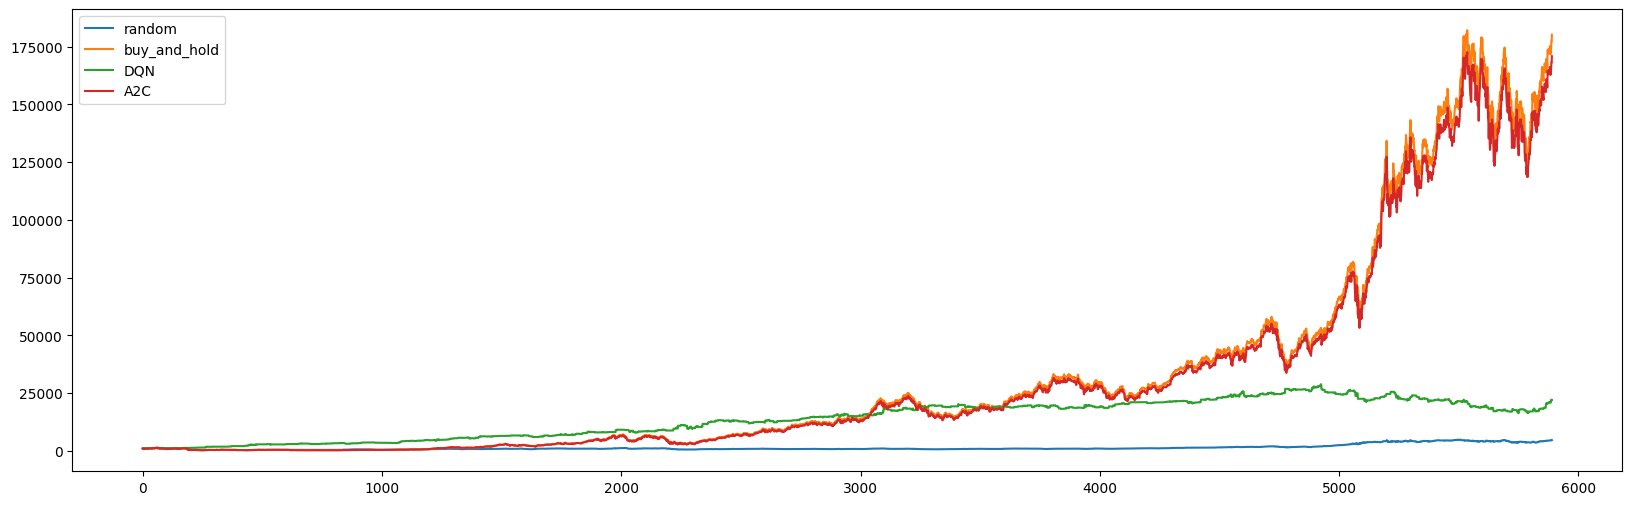

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(history_random, label="random")
plt.plot(history_buy_and_hold, label="buy_and_hold")
plt.plot(history_dqn, label="DQN")
plt.plot(history_a2c, label="A2C")
plt.legend()
plt.show()